## 1. Google Play Store apps and reviews
<p>Mobile apps are everywhere. They are easy to create and can be lucrative. Because of these two factors, more and more apps are being developed. In this notebook, we will do a comprehensive analysis of the Android app market by comparing over ten thousand apps in Google Play across different categories. We'll look for insights in the data to devise strategies to drive growth and retention.</p>
<p>Let's take a look at the data, which consists of two files:</p>
<ul>
<li><code>apps.csv</code>: contains all the details of the applications on Google Play. There are 13 features that describe a given app.</li>
<li><code>user_reviews.csv</code>: contains 100 reviews for each app, <a href="https://www.androidpolice.com/2019/01/21/google-play-stores-redesigned-ratings-and-reviews-section-lets-you-easily-filter-by-star-rating/">most helpful first</a>. The text in each review has been pre-processed and attributed with three new features: Sentiment (Positive, Negative or Neutral), Sentiment Polarity and Sentiment Subjectivity.</li>
</ul>

In [194]:
# Read in dataset
import pandas as pd
apps_with_duplicates = pd.read_csv('datasets/apps.csv')

# Drop duplicates from apps_with_duplicates
apps = apps_with_duplicates.drop_duplicates()

# Print the total number of apps
print('Total number of apps in the dataset = ', len(apps))

# Have a look at a random sample of 5 rows
apps.sample(5)

Total number of apps in the dataset =  9659


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4392,5347,Taha Al Junaid Quran Mp3,LIFESTYLE,4.6,518,4.2,"50,000+",Free,0,Everyone,Lifestyle,"March 25, 2017",1.1,2.3.3 and up
6487,7538,CM Launcher 3D Pro💎,PERSONALIZATION,4.7,23802,0.2,"100,000+",Paid,$4.99,Everyone,Personalization,"November 17, 2016",1.0.9,4.0 and up
8111,9231,Ec Solutions Mobile,BUSINESS,NaN,0,4.0,10+,Free,0,Everyone,Business,"November 20, 2016",1.02,4.1 and up
1403,1708,Toon Blast,GAME,4.7,1351068,NaN,"10,000,000+",Free,0,Everyone,Puzzle,"July 30, 2018",3196,4.1 and up
1348,1646,Bed Time Fan - White Noise Sleep Sounds,LIFESTYLE,4.5,10097,7.5,"500,000+",Free,0,Everyone,Lifestyle,"April 26, 2018",1.2,4.0 and up


## 2. Data cleaning
<p>Data cleaning is one of the most essential subtask any data science project. Although it can be a very tedious process, it's worth should never be undermined.</p>
<p>By looking at a random sample of the dataset rows (from the above task), we observe that some entries in the columns like <code>Installs</code> and <code>Price</code> have a few special characters (<code>+</code> <code>,</code> <code>$</code>) due to the way the numbers have been represented. This prevents the columns from being purely numeric, making it difficult to use them in subsequent future mathematical calculations. Ideally, as their names suggest, we would want these columns to contain only digits from [0-9].</p>
<p>Hence, we now proceed to clean our data. Specifically, the special characters <code>,</code> and <code>+</code> present in <code>Installs</code> column and <code>$</code> present in <code>Price</code> column need to be removed.</p>
<p>It is also always a good practice to print a summary of your dataframe after completing data cleaning. We will use the <code>info()</code> method to acheive this.</p>

In [196]:
# List of characters to remove
chars_to_remove = ['+', ',', '$']
# List of column names to clean
cols_to_clean = ['Installs', 'Price']

# Loop for each column in cols_to_clean
for col in cols_to_clean:
    # Loop for each char in chars_to_remove
    for char in chars_to_remove:
        # Replace the character with an empty string
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))
        
# Print a summary of the apps dataframe
print(apps.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9658
Data columns (total 14 columns):
Unnamed: 0        9659 non-null int64
App               9659 non-null object
Category          9659 non-null object
Rating            8196 non-null float64
Reviews           9659 non-null int64
Size              8432 non-null float64
Installs          9659 non-null object
Type              9659 non-null object
Price             9659 non-null object
Content Rating    9659 non-null object
Genres            9659 non-null object
Last Updated      9659 non-null object
Current Ver       9651 non-null object
Android Ver       9657 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB
None


## 3. Correcting data types
<p>From the previous task we noticed that <code>Installs</code> and <code>Price</code> were categorized as <code>object</code> data type (and not <code>int</code> or <code>float</code>) as we would like. This is because these two columns originally had mixed input types: digits and special characters.
<p>The four features that we will be working with most frequently henceforth are <code>Installs</code>, <code>Size</code>, <code>Rating</code> and <code>Price</code>. While <code>Size</code> and <code>Rating</code> are both <code>float</code> (i.e. purely numerical data types), we still need to work on <code>Installs</code> and <code>Price</code> to make them numeric.</p>

In [198]:
import numpy as np

# Convert Installs to float data type
apps['Installs'] = apps['Installs'].astype(float)

# Convert Price to float data type
apps['Price'] = apps['Price'].astype(float)

# Checking dtypes of the apps dataframe
print(apps.dtypes)

Unnamed: 0          int64
App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


## 4. Exploring app categories
<p>With more than 1 billion active users in 190 countries around the world, Google Play continues to be an important distribution platform to build a global audience. For businesses to get their apps in front of users, it's important to make them more quickly and easily discoverable on Google Play. To improve the overall search experience, Google has introduced the concept of grouping apps into categories.</p>
<p>This brings us to the following questions:</p>
<ul>
<li>Which category has the highest share of (active) apps in the market? </li>
<li>Is any specific category dominating the market?</li>
<li>Which categories have the fewest number of apps?</li>
</ul>
<p>We will see that there are <code>33</code> unique app categories present in our dataset. <em>Family</em> and <em>Game</em> apps have the highest market prevalence. Interestingly, <em>Tools</em>, <em>Business</em> and <em>Medical</em> apps are also at the top.</p>

In [200]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Print the total number of unique categories
num_categories = len(apps['Category'].unique())
print('Number of categories = ', num_categories)

# Count the number of apps in each 'Category'. 
num_apps_in_category = apps['Category'].value_counts()

# Sort num_apps_in_category in descending order based on the count of apps in each category
sorted_num_apps_in_category = num_apps_in_category.sort_values(ascending=False)

data = [go.Bar(
        x = num_apps_in_category.index, # index = category name
        y = num_apps_in_category.values, # value = count
)]

plotly.offline.iplot(data)

Number of categories =  33


## 5. Distribution of app ratings
<p>After having witnessed the market share for each category of apps, let's see how all these apps perform on an average. App ratings (on a scale of 1 to 5) impact the discoverability, conversion of apps as well as the company's overall brand image. Ratings are a key performance indicator of an app.</p>
<p>From our research, we found that the average volume of ratings across all app categories is <code>4.17</code>. The histogram plot is skewed to the left indicating that the majority of the apps are highly rated with only a few exceptions in the low-rated apps.</p>

In [202]:
# Average rating of apps
avg_app_rating = apps['Rating'].mean()
print('Average app rating = ', avg_app_rating)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = apps['Rating']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  4.173243045387994


## 6. Size and price of an app
<p>Let's now examine app size and app price. For size, if the mobile app is too large, it may be difficult and/or expensive for users to download. Lengthy download times could turn users off before they even experience your mobile app. Plus, each user's device has a finite amount of disk space. For price, some users expect their apps to be free or inexpensive. These problems compound if the developing world is part of your target market; especially due to internet speeds, earning power and exchange rates.</p>
<p>How can we effectively come up with strategies to size and price our app?</p>
<ul>
<li>Does the size of an app affect its rating? </li>
<li>Do users really care about system-heavy apps or do they prefer light-weighted apps? </li>
<li>Does the price of an app affect its rating? </li>
<li>Do users always prefer free apps over paid apps?</li>
</ul>
<p>We find that the majority of top rated apps (rating over 4) range from 2 MB to 20 MB. We also find that the vast majority of apps price themselves under \$10.</p>

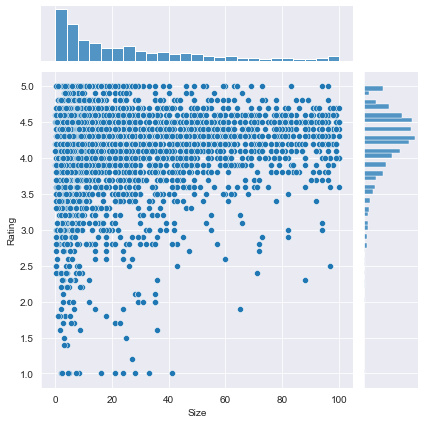

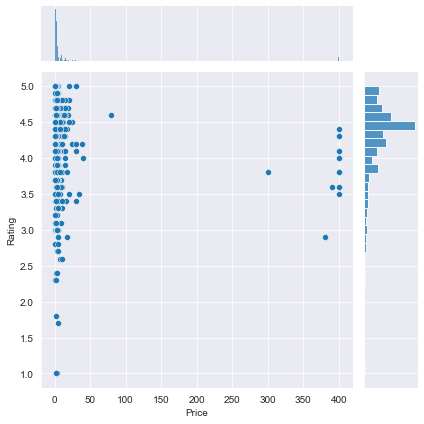

In [204]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

# Select rows where both 'Rating' and 'Size' values are present (ie. the two values are not null)
apps_with_size_and_rating_present = apps[(~apps['Rating'].isnull()) & (~apps['Size'].isnull())]

# Subset for categories with at least 250 apps
large_categories = apps_with_size_and_rating_present.groupby(['Category']).filter(lambda x: len(x) >= 250)

# Plot size vs. rating
plt1 = sns.jointplot(x = large_categories['Size'], y = large_categories['Rating'])

# Select apps whose 'Type' is 'Paid'
paid_apps = apps_with_size_and_rating_present[apps_with_size_and_rating_present['Type'] == 'Paid']

# Plot price vs. rating
plt2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'])

## 7. Relation between app category and app price
<p>So now comes the hard part. How are companies and developers supposed to make ends meet? What monetization strategies can companies use to maximize profit? The costs of apps are largely based on features, complexity, and platform.</p>
<p>There are many factors to consider when selecting the right pricing strategy for your mobile app. It is important to consider the willingness of your customer to pay for your app. A wrong price could break the deal before the download even happens. Potential customers could be turned off by what they perceive to be a shocking cost, or they might delete an app they’ve downloaded after receiving too many ads or simply not getting their money's worth.</p>
<p>Different categories demand different price ranges. Some apps that are simple and used daily, like the calculator app, should probably be kept free. However, it would make sense to charge for a highly-specialized medical app that diagnoses diabetic patients. Below, we see that <em>Medical and Family</em> apps are the most expensive. Some medical apps extend even up to \$80! All game apps are reasonably priced below \$20.</p>

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


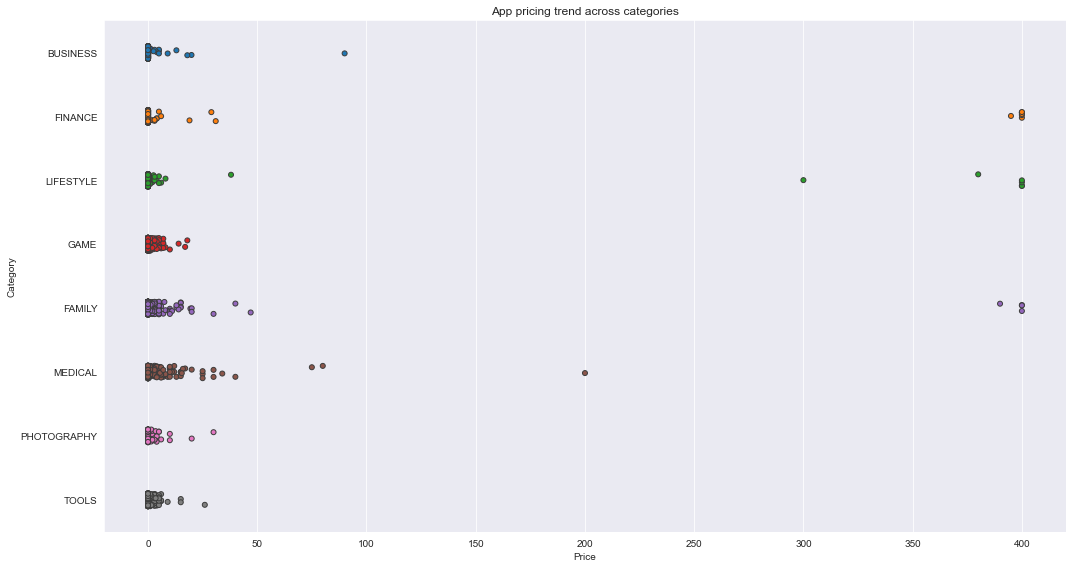

In [206]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Select a few popular app categories
popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Examine the price trend by plotting Price vs Category
ax = sns.stripplot(x = popular_app_cats['Price'], y = popular_app_cats['Category'], jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories')

# Apps whose Price is greater than 200
apps_above_200 = apps[apps['Price'] > 200]
apps_above_200[['Category', 'App', 'Price']]

## 8. Filter out "junk" apps
<p>It looks like a bunch of the really expensive apps are "junk" apps. That is, apps that don't really have a purpose. Some app developer may create an app called <em>I Am Rich Premium</em> or <em>most expensive app (H)</em> just for a joke or to test their app development skills. Some developers even do this with malicious intent and try to make money by hoping people accidentally click purchase on their app in the store.</p>
<p>Let's filter out these junk apps and re-do our visualization.</p>

Text(0.5, 1.0, 'App pricing trend across categories after filtering for junk apps')

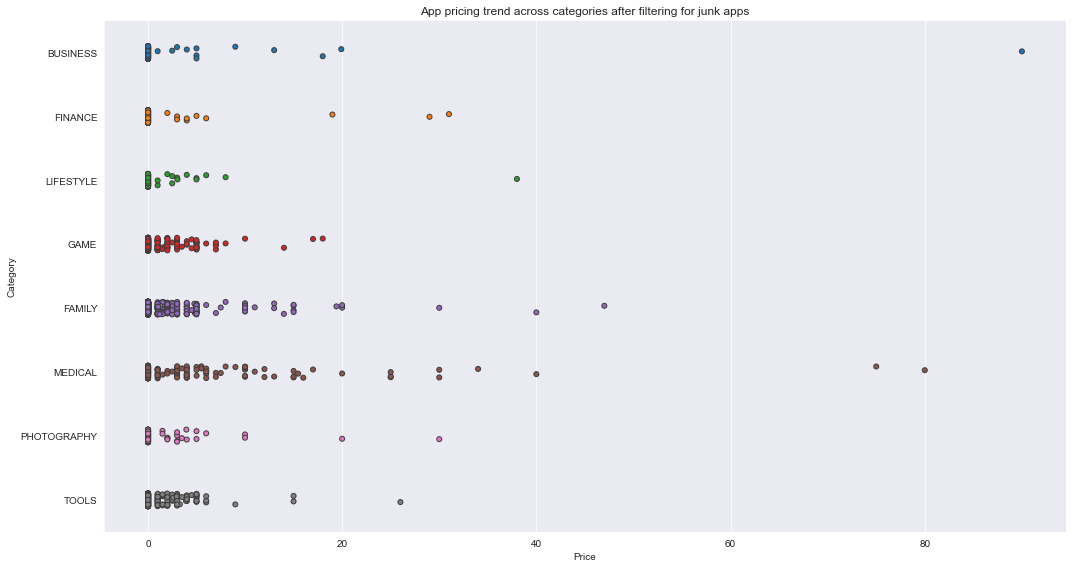

In [208]:
# Select apps priced below $100
apps_under_100 = popular_app_cats[popular_app_cats['Price'] < 100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Examine price vs category with the authentic apps (apps_under_100)
ax = sns.stripplot(x = apps_under_100['Price'], y = apps_under_100['Category'], data = apps, jitter = True, linewidth = 1)
ax.set_title('App pricing trend across categories after filtering for junk apps')

## 9. Popularity of paid apps vs free apps
<p>For apps in the Play Store today, there are five types of pricing strategies: free, freemium, paid, paymium, and subscription. Let's focus on free and paid apps only. Some characteristics of free apps are:</p>
<ul>
<li>Free to download.</li>
<li>Main source of income often comes from advertisements.</li>
<li>Often created by companies that have other products and the app serves as an extension of those products.</li>
<li>Can serve as a tool for customer retention, communication, and customer service.</li>
</ul>
<p>Some characteristics of paid apps are:</p>
<ul>
<li>Users are asked to pay once for the app to download and use it.</li>
<li>The user can't really get a feel for the app before buying it.</li>
</ul>
<p>Are paid apps installed as much as free apps? It turns out that paid apps have a relatively lower number of installs than free apps, though the difference is not as stark as I would have expected!</p>

In [210]:
trace0 = go.Box(
    # Data for paid apps
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Data for free apps
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(title = "Log number of downloads",
                type = 'log',
                autorange = True)
)

# Add trace0 and trace1 to a list for plotting
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

## 10. Sentiment analysis of user reviews
<p>Mining user review data to determine how people feel about your product, brand, or service can be done using a technique called sentiment analysis. User reviews for apps can be analyzed to identify if the mood is positive, negative or neutral about that app. For example, positive words in an app review might include words such as 'amazing', 'friendly', 'good', 'great', and 'love'. Negative words might be words like 'malware', 'hate', 'problem', 'refund', and 'incompetent'.</p>
<p>By plotting sentiment polarity scores of user reviews for paid and free apps, we observe that free apps receive a lot of harsh comments, as indicated by the outliers on the negative y-axis. Reviews for paid apps appear never to be extremely negative. This may indicate something about app quality, i.e., paid apps being of higher quality than free apps on average. The median polarity score for paid apps is a little higher than free apps, thereby syncing with our previous observation.</p>
<p>In this notebook, we analyzed over ten thousand apps from the Google Play Store. We can use our findings to inform our decisions should we ever wish to create an app ourselves.</p>

Text(0.5, 1.0, 'Sentiment Polarity Distribution')

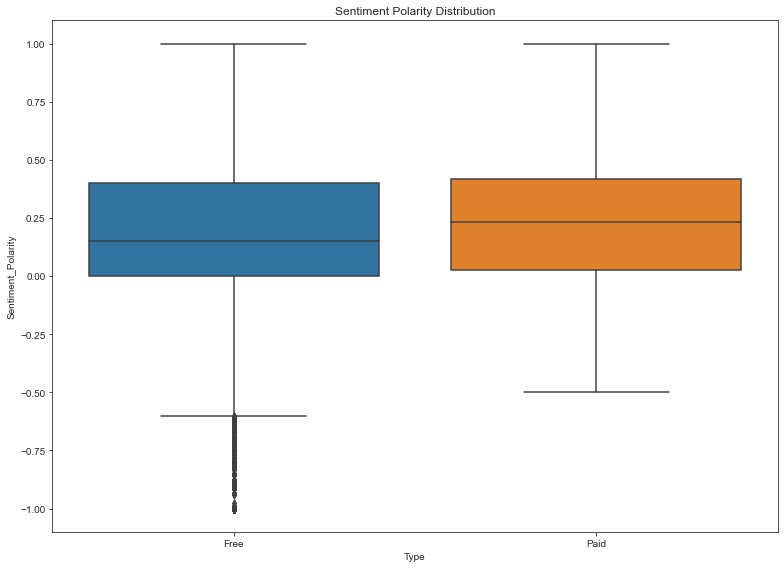

In [212]:
# Load user_reviews.csv
reviews_df = pd.read_csv('datasets/user_reviews.csv')

# Join the two dataframes
merged_df = pd.merge(apps, reviews_df, on = 'App', how = "inner")

# Drop NA values from Sentiment and Review columns
merged_df = merged_df.dropna(subset = ['Sentiment', 'Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# User review sentiment polarity for paid vs. free apps
ax = sns.boxplot(x = 'Type', y = 'Sentiment_Polarity', data = merged_df)
ax.set_title('Sentiment Polarity Distribution')